In [1]:
%load_ext autoreload
%autoreload 2
from iminuit import Minuit
import numpy as np
import emcee
import scipy
import matplotlib.pyplot as plt
from scipy.integrate import dblquad
import DATAOPS_Importance_Sampling as imp_sampling
from scipy.stats import multivariate_normal

# Toy model

In [2]:
#define 2-parameters model
ndim = 2
def model(a, b, x): return b*x**(-a)
a_true = 1
b_true = 1

## data

In [3]:
x_data = np.linspace(0.1, 1, 30)
sigma = np.sqrt(1)
#generate measured data
y_data = model(a_true, b_true, x_data) + np.random.randn(len(x_data))*sigma
cov_data = sigma**2*np.diag(np.linspace(1, 1, len(x_data)))
inv_cov_data = np.linalg.inv(cov_data)

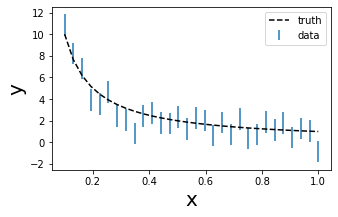

In [4]:
plt.figure(figsize = (5,3))
plt.errorbar(x_data, y_data, sigma, fmt = ' ', label = 'data')
plt.plot(x_data, model(a_true, b_true, x_data), '--k', label = 'truth')
plt.xlabel('x', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.legend()
plt.show()

## best fit and contour plot with Minuit

In [5]:
def m_lnlikelihood(a,b):
    expected = model(a,b, x_data)
    return -np.log(multivariate_normal.pdf(y_data, expected, cov_data))

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


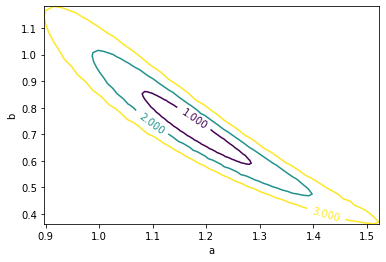

In [6]:
m = Minuit(m_lnlikelihood, a = 0, b = 0, errordef = .5, limit_a = [-10,10], limit_b = [-10,10])
m.migrad()
m.minos()
m.hesse()
m.draw_mncontour('a','b', nsigma = 3)
plt.show()

In [7]:
S11 = m.covariance[('a', 'a')]
S22 = m.covariance[('b', 'b')]
S12 = m.covariance[('a', 'b')]

# Importance Sampling

## Create $N$ samples from a proposition distribution $q(x)$

In [8]:
#limits
a_limit = m.values['a'] + np.array([-3*m.errors['a'], 3*m.errors['a']])
b_limit = m.values['b'] + np.array([-3*m.errors['b'], 3*m.errors['b']])
limits = [a_limit, b_limit]

### Define $q(x)$

In [9]:
def m_a(b): return a_true + S12*(S22**(-1))*(b-b_true)

$$ \langle a|b \rangle = a_0 + \frac{\Sigma_{12}}{\Sigma_{22}}(b-b_0) $$

In [10]:
#q proposition
def q(x):
    a, b = x
    #prior
    if not a_limit[0] <= a <= a_limit[1]: return 0
    if not b_limit[0] <= b <= b_limit[1]: return 0
    #gaussian proposition
    sigma = .2
    return multivariate_normal.pdf(a, m_a(b), .1) * multivariate_normal.pdf(b, b_true, .1)

In [11]:
qmax = q([a_true, b_true])

### Create samples from $q(x)$

In [12]:
rand, q_val = imp_sampling.compute_position_from_distribution(ndim = ndim, pdf = q, pdf_max = qmax, N_points = 1000, limits = limits)

acceptance = 0.5136106831022085


In [13]:
a, b = rand[:,0], rand[:,1]

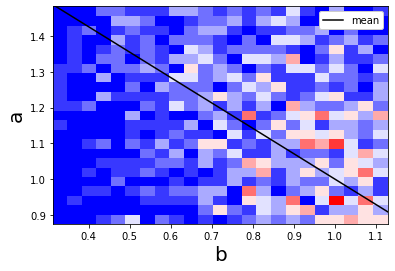

In [14]:
b_axis = np.linspace(b_limit[0], b_limit[1], 100)
plt.plot(b_axis, m_a(b_axis), 'k', label='mean')
plt.hist2d(b, a, bins = [23, 23], cmap = 'bwr')
plt.xlabel('b', fontsize = 20)
plt.ylabel('a', fontsize = 20)
plt.legend(framealpha = 1)
plt.show()


### Compute model for each sample 

In [15]:
def model_theta(theta): 
    a, b = theta
    return model(a, b, x_data)

In [16]:
tab_model = imp_sampling.compute_model([a,b], model = model_theta)

In [17]:
pos = rand
def model_theta_n(n): return model_theta(pos[n])

In [18]:
tab_model = imp_sampling.map(model_theta_n, np.arange(len(a)))

You have 8 CPUs


### Compute weights $w_i = P(x_i|\mbox{data})/q(x_i)$

In [19]:
# create data

In [20]:
def posterior(expected, data):
    return multivariate_normal.pdf(y_data, expected, cov_data)

In [21]:
#compute likelihood
posterior_tab = imp_sampling.compute_posterior(posterior = posterior, model_tab = tab_model, data = y_data)

In [22]:
#compute weights
w = posterior_tab/q_val

# Monte-Carlo Markov Chains approach

In [23]:
def lnlikelihood_emcee(theta):
    a, b = theta
    return -m_lnlikelihood(a,b)

In [24]:
initial = [a_true, b_true]
npath = 300
nwalkers = 200
#starting from the q-distrib
pos = np.array([[a_,b_] for a_, b_ in zip(a,b)])[0:nwalkers]
nwalkers, ndim = pos.shape

sampler_param = emcee.EnsembleSampler(nwalkers, ndim, lnlikelihood_emcee)
sampler_param.run_mcmc(pos, npath, progress=True);

  0%|          | 0/300 [00:00<?, ?it/s]/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 300/300 [00:18<00:00, 15.79it/s]


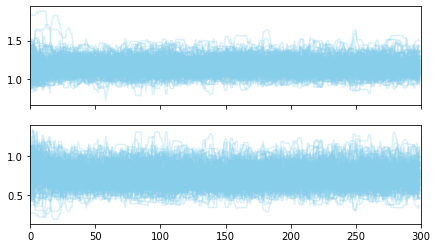

In [25]:
fig, axes = plt.subplots(2, figsize=(7, 4), sharex=True)
samples = sampler_param.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3, c = 'skyblue')
    ax.set_xlim(0, len(samples))

In [26]:
mcmc = sampler_param.get_chain(discard = 200, thin = 2, flat = True)

# Comparison between MCMC and IS

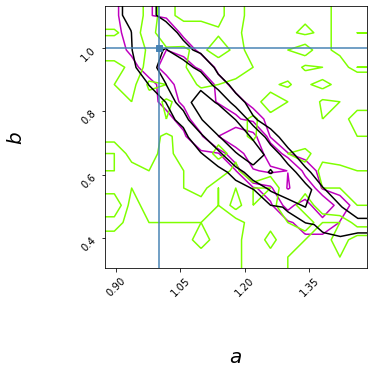

In [27]:
import corner
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
fig, axs = plt.subplots(2,2, figsize = (10,10))
pos_emcee = [[a_,b_] for a_, b_ in zip(a,b)]
bins = 15
c = ['m', 'r']
#axs[1,0].scatter(a, b, s = .1, c = 'chartreuse')
extent = [a_limit, b_limit]
corner.corner(pos_emcee, fig = fig, bins=bins, levels=(sigma1, sigma2, sigma3), 
            fill_contours=False, plot_contours = True,
            label_kwargs={"fontsize": 20}, top_ticks = True,
            plot_density=False,
            max_n_ticks = 6,
              scale_hist = True,
            weights=w/np.sum(w),
              plot_datapoints=False,
            color = 'm',
            show_title= True,labels = [r'$a$', r'$b$'],
              )
corner.corner(pos_emcee, fig = fig, bins=bins, levels=(sigma1, sigma2, sigma3), 
            fill_contours=False, plot_contours = True,
            label_kwargs={"fontsize": 20}, top_ticks = True,
            plot_density=False,
              plot_datapoints=False,
            color = 'chartreuse',
            show_title= True,labels = [r'$a$', r'$b$'],
              )
corner.corner(mcmc, fig = fig, bins=bins, levels=(sigma1, sigma2, sigma3), 
            fill_contours=False, plot_contours = True,
            plot_datapoints=False,
            label_kwargs={"fontsize": 20},
            plot_density=False,
            quantiles = [.5], 
            weights=None,
            color = 'k',truths = [a_true, b_true],labels = [r'$a$', r'$b$'],
             range = extent)

axs[0,1].plot([],[], 'chartreuse', linewidth = 10, label = 'proposal (IS)')
axs[0,1].plot([],[], 'm', linewidth = 10, label = 'posterior (IS)')
axs[0,1].plot([],[], 'k', linewidth = 10, label = 'posterior (MCMC)')
axs[0,1].legend(frameon = False, fontsize = 14)
plt.rcParams['axes.linewidth'] = 1.3
axs[0,1].tick_params(axis='both', which = 'major', labelsize= 15)
fig.delaxes(axs[0,0])
fig.delaxes(axs[0,1])
fig.delaxes(axs[1,1])
plt.show()

# *appendix: Interpolated posterior

In [28]:
n = 1000
#scipy interpolation
posterior_interpolated = scipy.interpolate.Rbf(rand[:,0][np.arange(n)], rand[:,1][np.arange(n)], 
                                               posterior_tab[np.arange(n)], 
                                               function = 'multiquadric')

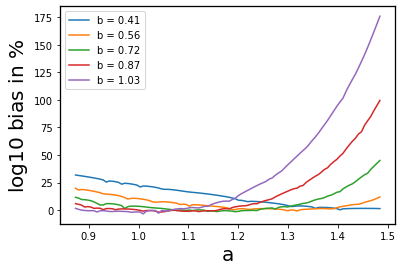

In [29]:
a_axis = np.linspace(a_limit[0], a_limit[1], 100)
for b_true in np.linspace(b_limit[0]+.1, b_limit[1]-.1, 5):
    y_interp = np.array([posterior_interpolated(a_, b_true) for a_ in a_axis])
    y_true = np.array([np.exp(-m_lnlikelihood(a_,b_true)) for a_ in a_axis])
    plt.plot(a_axis, np.log10(abs(100*(y_interp-y_true)/y_true)), label = f'b = {b_true:.2f}')
plt.xlabel('a', fontsize = 20)
plt.ylabel('log10 bias in $\%$', fontsize = 20)
plt.legend()